In [1]:
from nequ_nn import NequIP
import torch
import torch.nn as nn
from torch_cluster import radius_graph
from torch_geometric.data import Data, DataLoader
from torch_scatter import scatter

from e3nn import o3
from e3nn.nn import FullyConnectedNet, Gate
from e3nn.o3 import FullyConnectedTensorProduct
from e3nn.math import soft_one_hot_linspace
from e3nn.util.test import assert_equivariant
from radial_basis import distance_embedding
from nequ_nn_conv import Convolution

device = 'cuda'
# Split the data into training and validation sets
train_size = 1500
val_size = 500

import numpy as np 
data = np.load('aspirin-2000.npz')
z_atom = data['z']
positions = data['R']
atomic_list = np.unique(z_atom).tolist()
atom_types = np.zeros_like(positions[:,:,0], dtype=int)
for iframe in range(len(positions)):
    atom_types[iframe] = z_atom

energies = data['E']
forces = data['F']

# Convert numpy arrays to PyTorch tensors
positions_tensor = torch.tensor(positions, dtype=torch.float32).to(device)
energies_tensor = torch.tensor(energies, dtype=torch.float32).to(device)
forces_tensor = torch.tensor(forces, dtype=torch.float32).to(device)
atom_types_tensor = torch.tensor(atom_types, dtype=torch.long).to(device)

#shift energy 
energies_tensor = energies_tensor - torch.mean(energies_tensor)

train_positions = positions_tensor[:train_size]
train_energies = energies_tensor[:train_size]
train_forces = forces_tensor[:train_size]
train_atom_types = atom_types_tensor[:train_size]

val_positions = positions_tensor[train_size:]
val_energies = energies_tensor[train_size:]
val_forces = forces_tensor[train_size:]
val_atom_types = atom_types_tensor[train_size:]

model = NequIP(atomic_list, cutoff=4.0,lmax = 1).to(device)
model.load_state_dict(torch.load('best_model.pth'))

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


1111111111111111111111111
22222222222222222222222222


/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


!!!!!!!!!!!!!!!!!
33333333333333333333333
44444444444444444444444
in out of the first conv =  4x0e 4x0e+8x0e+4x1o+4x1o+4x2e+4x2e


/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute

in out of the second conv =  4x0e+8x0e+4x1o+4x1o+4x2e+4x2e 16x0o+12x0e+4x1o+4x1e+4x2o+4x2e


/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/yaoluo/anaconda3/envs/python-torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/tmp/ipykernel_624116/2230165698.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

In [2]:
import time 
t_1 = time.time()
E = [] 
F = [] 
for i in range(val_size):
   # Forward pass
   predicted_energy, predicted_forces = model.compute_forces(val_atom_types[i], val_positions[i])
   E.append(predicted_energy.cpu().detach().numpy())
   F.append(predicted_forces.cpu().detach().numpy())
print("t for predicting = ", time.time()- t_1,"sec")


t for predicting =  11.588002443313599 sec


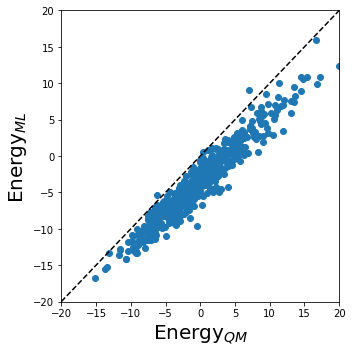

In [3]:
# 
import matplotlib.pyplot as plt 
import numpy as np 
E = np.asarray(E)

import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
predicted_energy = np.asarray(E)
plt.scatter(val_energies.cpu().detach().numpy(), predicted_energy,zorder=-1)

plt.xlim([-20,20])
plt.ylim([-20,20])
plt.plot([-20,20],[-20,20],zorder=1,c = 'k', linestyle='--')

plt.xlabel(r'Energy$_{QM}$', fontsize=20)
plt.ylabel(r'Energy$_{ML}$', fontsize=20)
plt.tight_layout()
plt.savefig('fit-E.jpg', dpi = 500)


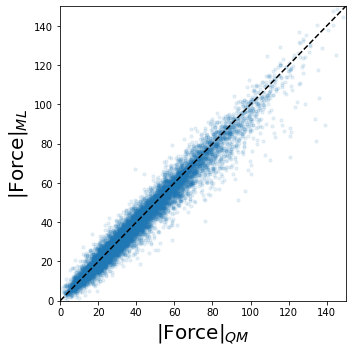

In [4]:
plt.figure(figsize=(5,5))
predicted_f_abs =np.sum(  np.asarray(F)**2 ,-1)**0.5 
val_f_abs = np.sum( val_forces.cpu().detach().numpy()**2 ,-1)**0.5 
plt.scatter(val_f_abs, predicted_f_abs,s=10,alpha=0.1,zorder=-1)

plt.xlim([0,150])
plt.ylim([0,150])
plt.plot([0,150],[0,150],zorder=1,c = 'k', linestyle='--')
plt.xlabel(r'|Force|$_{QM}$', fontsize=20)
plt.ylabel(r'|Force|$_{ML}$', fontsize=20)
plt.tight_layout()
plt.savefig('fit-F.jpg', dpi = 500)


np.save("|F|_validation.npy",val_f_abs)
np.save("|F|_nn.npy",predicted_f_abs)